In [70]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


# Parameters
L = 2.0             # Length of the beam [m]
EI = 2e6            # Flexural rigidity [Nm^2]
Q = 1000.0 # Uniform load [N/m]
P = 500.0           # Point load [N]
a = L / 4            # Load applied at midspan
hinge_loc = 2 * L / 5.

colloc_width = L / 4.
colloc_density = 20

dl = 0.01 * L

act = 'swish'

ASYM = True
UDL = False

Noise = False
USE_COLLOC = False
Use_Max = False 
CAP = True
cap_val_min = 1e-4
cap_val_max = 1e4

In [66]:
x_full = np.linspace(0, L, 200)
x_full_norm = x_full/ L

def w(x, L, Q):
  w = (Q * x**2 * (6*L**2 - 4*L*x + x**2)) / (24 * EI)
  return tf.cast(w, dtype = tf.float32)

def w_point_load(x, L, P, a):
    w = np.zeros_like(x)
    mask1 = x <= a
    mask2 = x > a
    w[mask1] = (P * x[mask1]**2 * (3*a - x[mask1])) / (6 * EI)
    w[mask2] = (P * a**2 * (3*x[mask2] - a)) / (6 * EI)
    return tf.cast(w, dtype = tf.float32)

def w_point_load_new(x, P, a, constants, smooth = False):
    
    A, B, C, D = constants
    k = P / EI
    if smooth:
        H = tf.sigmoid(100 * (x - a))
    else:
        H = tf.where(x < a, 0.0, 1.0) 
        
    w = tf.cast(A / 6 * x**3 + 
                B / 2 * x**2 + 
                C * x + 
                D + 
                k / 6 * (x - a)**3 * H, dtype = tf.float32)
    return w

def w_udl_new(x, Q, constants):
    
    A, B, C, D = constants
    k = Q / EI

    w = tf.cast(k / 24 * x**4 +
                A / 6 * x**3  + 
                B / 2 * x**2  + 
                C * x         + 
                D, dtype = tf.float32)
    return w

def get_constants(L, P, Q, a, Case):
    
    kp = P / EI
    kq = Q / EI
    
    cantilever_constants_udl = [-L * kq, (L**2 * kq) / 2, 0, 0]
    cantilever_constants_pl = [-kp, kp * a, 0, 0]

    simply_supported_constants_udl = [-(L * kq)/ 2, 0, (L**3 * kq) / 24, 0]
    simply_supported_constants_pl = [-kp * (L - a) / L, 0, kp * a * (L - a) * (2 * L - a) / (6 * L), 0]

    clamped_constants_udl = [-(L * kq) / 2, (L**2 * kq) / 12, 0, 0]
    clamped_constants_pl = [-kp * (L - a)**2 * (L + 2 * a) / L**3, kp * a * (L - a)**2 / L**2, 0, 0]

    if Case == 'Cantilever':
        constants_udl = cantilever_constants_udl
        constants_pl = cantilever_constants_pl
    elif Case == 'SS':
        constants_udl = simply_supported_constants_udl
        constants_pl = simply_supported_constants_pl
    elif Case == 'Clamped':
        constants_udl = clamped_constants_udl
        constants_pl = clamped_constants_pl
    
    return constants_udl, constants_pl

  

In [ ]:
def w_udl_mid_hinge(x, L, Q):
  hinge_loc = L / 2.
  x_left, x_right = x[x <= hinge_loc], x[hinge_loc < x]

  return np.concatenate([w(x_left, hinge_loc, Q), w(L - x_right, L - hinge_loc, Q)])

def w_pl_mid_hinge(x, L, P, a):
  hinge_loc = L / 2.
  x_left, x_right = x[x <= hinge_loc], x[hinge_loc < x]
  return np.concatenate([w_point_load(x_left, hinge_loc, P, a), w_point_load(L - x_right, L - hinge_loc, P, a)])

def get_shear(a, b, L, Q, P):
    t1 = a**2 * (b / 2 - a / 6) * P
    t2 = Q / 8 * ((L - b)**4 - b**4)
    t3 = 1 / 3 * ((L - b)**3 + b**3)
    V = (t1 - t2) / t3
    return V

def w_one_hinge(x, L, Q, P, a):
  
  shear = get_shear(a, hinge_loc, L, Q, P)
  x_left = x[x <= hinge_loc]
  w_left = w(x_left, hinge_loc, Q) + w_point_load(x_left, hinge_loc, P, a) + w_point_load(x_left, hinge_loc, -shear, hinge_loc)
  x_right = x[x > hinge_loc]
  w_right = w(L - x_right, L - hinge_loc, Q) + w_point_load(L - x_right, L - hinge_loc, shear, L - hinge_loc)
  
  return np.concatenate([w_left, w_right])

def get_collocation_points(x_sensors, pred_hinge_loc, colloc_width, colloc_density):

    hinge_start = pred_hinge_loc - colloc_width / 2.
    hinge_end = pred_hinge_loc + colloc_width / 2.
    
    dense_sensors = tf.linspace(hinge_start, hinge_end, colloc_density)
    dense_sensors = tf.cast(tf.reshape(dense_sensors, (-1, 1)), dtype=tf.float32)
    x_colloc = tf.concat((x_sensors, dense_sensors), axis=0)
    
    return tf.sort(x_colloc, axis=0)

In [68]:
def gaussian_prop(x, x_p, P, sigma=0.01):
     # scale height so area = total_force
    return  P * np.exp(-0.5 * ((x - x_p) / sigma) ** 2)

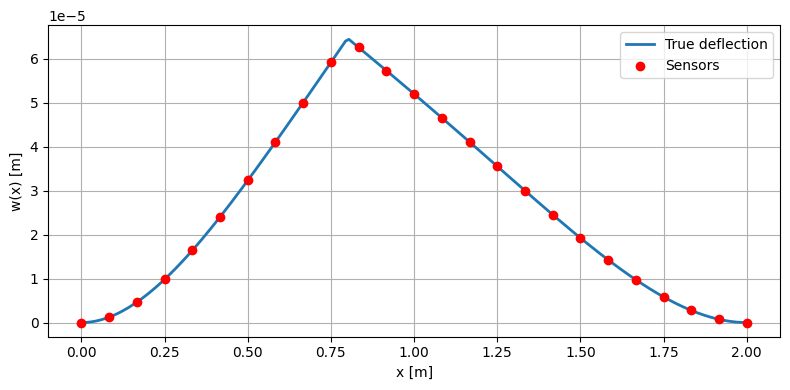

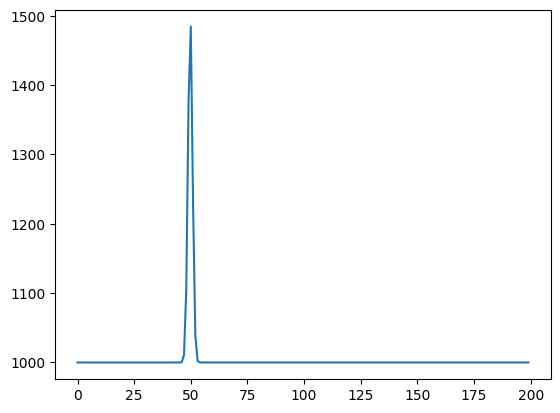

In [ ]:
x_full = np.linspace(0, L, 200)
x_sensors = np.linspace(0, L, 25)

def get_shear(a, b, L, Q, P):
    t1 = a**2 * (b / 2 - a / 6) * P
    t2 = Q / 8 * ((L - b)**4 - b**4)
    t3 = 1 / 3 * ((L - b)**3 + b**3)
    V = (t1 - t2) / t3
    return V
  
def get_collocation_points(x_sensors, pred_hinge_loc, colloc_width, colloc_density):

  hinge_start = pred_hinge_loc - colloc_width / 2.
  hinge_end = pred_hinge_loc + colloc_width / 2.
  
  dense_sensors = tf.linspace(hinge_start, hinge_end, colloc_density)
  dense_sensors = tf.cast(tf.reshape(dense_sensors, (-1, 1)), dtype=tf.float32)
  x_colloc = tf.concat((x_sensors, dense_sensors), axis=0)
  
  return tf.sort(x_colloc, axis=0)
  
def get_w_udl(x):
  hinge_loc = L / 2
  x_left = x[x <= hinge_loc]
  x_right = x[x > hinge_loc]
  
  constant_udl, _ = get_constants(L / 2.0, P, Q, a, 'Cantilever')
  w_true_l = w_udl_new(x_left, Q, constant_udl)
  w_true_r = w_udl_new(L - x_right, Q, constant_udl)
  w= tf.concat((w_true_l, w_true_r), 0)
  return w

def get_w_asym(x):
  
  x_left = x[x <= hinge_loc]
  x_right = x[x > hinge_loc]
  
  constant_udl_l, constant_pl_l = get_constants(hinge_loc, P, Q, a, 'Cantilever')
  constant_udl_r, _ = get_constants(L - hinge_loc, P, Q, a, 'Cantilever')
  
  shear = get_shear(a, hinge_loc, L, Q, P)
  _, shear_constant_l = get_constants(hinge_loc, -shear, Q, hinge_loc, 'Cantilever')
  _, shear_constant_r = get_constants(L - hinge_loc, shear, Q, L - hinge_loc, 'Cantilever')
  
  w_true_l = w_point_load_new(x_left, P, a, constant_pl_l, smooth = False) + w_udl_new(x_left, Q, constant_udl_l) + w_point_load_new(x_left, -shear, hinge_loc, shear_constant_l, smooth = False)
  w_true_r = w_udl_new(L - x_right, Q, constant_udl_r) + w_point_load_new(L - x_right, shear, L - hinge_loc, shear_constant_r, smooth = False)
  w = tf.concat((w_true_l, w_true_r), 0)
  return w
  
def get_w_comb_sym(x):
  hinge_loc = L / 2
  x_left = x[x <= hinge_loc]
  x_right = x[x > hinge_loc]
  
  constant_udl, constant_pl = get_constants(L / 2.0, P, Q, a, 'Cantilever')
  w_true_l = w_point_load_new(x_left, P, a, constant_pl, smooth = False) + w_udl_new(x_left, Q, constant_udl)
  w_true_r = w_point_load_new(L - x_right, P, a, constant_pl, smooth = False) + w_udl_new(L - x_right, Q, constant_udl)
  w = tf.concat((w_true_l, w_true_r), 0) + w_udl_mid_hinge(x, L, Q)
  return w

if UDL:
  w_true = get_w_udl(x_full)
  w_sensors_clean = get_w_udl(x_sensors)
  q_true = Q * tf.ones([200,1])
  q_max = Q
  
elif ASYM:
  w_true = get_w_asym(x_full)
  w_sensors_clean = get_w_asym(x_sensors)
  q_true = Q * tf.ones([200,1]) + gaussian_prop(tf.convert_to_tensor(x_full.reshape(-1,1), dtype=tf.float32), a, P, sigma=0.01)
  q_max = Q
  
else:
  w_true = get_w_comb_sym(x_full)
  w_sensors_clean = get_w_comb_sym(x_sensors)
  q_true = Q * tf.ones([200,1]) + gaussian_prop(tf.convert_to_tensor(x_full.reshape(-1 , 1), dtype=tf.float32), L / 4, P, sigma=0.05) + gaussian_prop(tf.convert_to_tensor(x_full.reshape(-1, 1), dtype=tf.float32), 3 * L / 4, P, sigma=0.05)
  q_max = P 
w_sensors = w_sensors_clean

if Noise:
  np.random.seed(42)
  noise_std = 0.05 * np.max(w_sensors_clean)
  noise = np.random.normal(0, noise_std, size=w_sensors_clean.shape)
  w_sensors += noise

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_full, w_true, label="True deflection", linewidth=2)

plt.scatter(x_sensors, w_sensors, color='red', label="Sensors", zorder=3)
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(q_true)

In [5]:
def get_shear(a, b, L, P, Q):
    t1 = a**2 * (b / 2 - a / 6) * P
    t2 = Q / 8 * ((L - b)**4 - b**4)
    t3 = 1 / 3 * ((L - b)**3 + b**3)
    V = (t1 - t2) / t3
    return V
shear = get_shear(a, hinge_loc, L, P, Q)

shear


-227.3148148148148

([<matplotlib.lines.Line2D at 0x30304a540>],
 Text(0.5, 1.0, 'Deflection w(x)'),
 Text(0.5, 0, 'x (m)'),
 Text(0, 0.5, 'w (m)'))

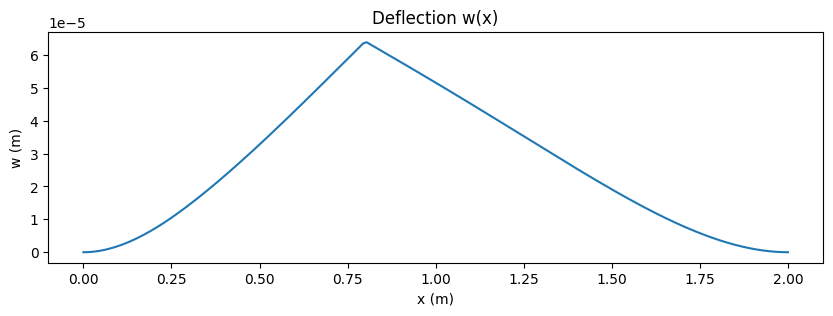

In [6]:
x_left = x_full[x_full <= hinge_loc]
w_left = w(x_left, hinge_loc, Q) + w_point_load(x_left, hinge_loc, P, a) + w_point_load(x_left, hinge_loc, -shear, hinge_loc)
x_right = x_full[x_full > hinge_loc]
w_right = w(L - x_right, L - hinge_loc, Q) + w_point_load(L - x_right, L - hinge_loc, shear, L - hinge_loc)

plt.figure(figsize=(10, 3))
plt.plot(x_full, np.concatenate([w_left, w_right])), plt.title("Deflection w(x)"), plt.xlabel("x (m)"), plt.ylabel("w (m)")

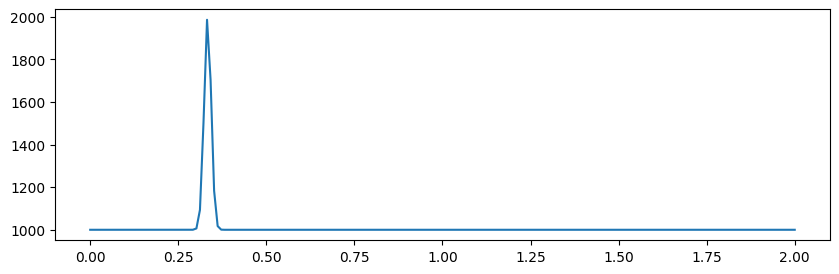

In [7]:
q_true = np.ones_like(x_full) * Q + gaussian_prop(x_full, a, P)
plt.figure(figsize=(10, 3)) 
plt.plot(x_full, q_true)

In [65]:
def norm_sig(x_norm, k):
    return 2 * (tf.sigmoid(k*x_norm) - 0.5)

def sigmoid_scale(phys_lb, sigmoid_amplitude, characteristic_length_scacle):
    characteristic_amplitude = norm_sig(characteristic_length_scacle, 1)
    sigmoid_scale = characteristic_length_scacle / (1 - characteristic_amplitude * sigmoid_amplitude / phys_lb)
    return sigmoid_scale

tf.Tensor(0.90514827, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=13.198600769042969>

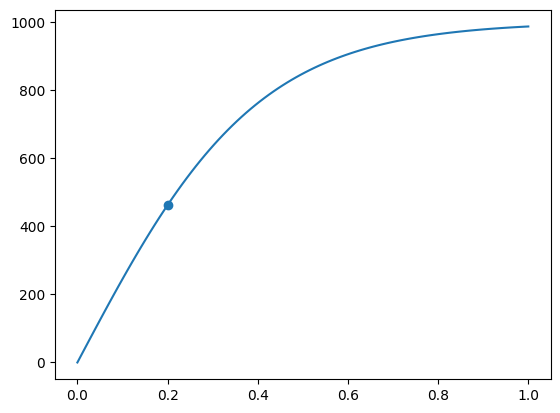

In [102]:
x_norm = tf.linspace(0, 1, 100)
fexp = tf.exp(5 * x_norm) 
flog = 1e3 * tf.math.log(x_norm + 1)
fsoft = tf.math.softplus(x_norm)

A = 1e3
k = 5
lc = 1 / k
print(norm_sig(3/10, 10))

fsig = A * norm_sig(x_norm, k)

plt.plot(x_norm, fsig)
plt.scatter(lc, A * norm_sig(lc, k))

phys_min = A * norm_sig(lc, k) / (1 - lc)
phys_min
sigmoid_scale(1e9 * (5e-3)**4, 0.1, 5.)
sigmoid_scale(0.5, 1., 1.)

In [105]:
1e8 * (5e-3)**4

0.0625